In [44]:
import PyHeston
import numpy
import itertools

from BlackScholes import *
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv
import math

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
# from Utilis/heston import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sp
from heston import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
nInt = 1024
r0 = 0.0002
S= 100
K = 100
#T = 0.01
r = r0
sigma = 0.1 #0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
T = 2.0

In [13]:
training_number = 30 # change training size 
testing_number = 40   #use all data as test, otherwise shape not match


x1_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.05,1.0, training_number), dtype='float32').reshape(training_number, 1)


X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:,0] = X1_train.flatten()
x_train[:,1] = X2_train.flatten()

In [14]:

#x1_test = torch.linspace(0, 1.0, testing_number)
#x2_test = torch.linspace(0.05, 1.0, testing_number)
x1_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

In [15]:
nt = 11
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

In [16]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        print(time)
        
        y_train = []
        
        for idx in range(len(x_train)):
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_train.append(f(x_train[idx,0], x_train[idx,1], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [17]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
                
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_test_.append(f(x_test[idx,0], x_test[idx,1], time))
            
        print(len(x_test), len(y_test_))
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [18]:
lb = 1
ub = 400
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y,z: PyHeston.HestonCall(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)
portfolio['put']['price']= lambda x,y,z: PyHeston.HestonPut(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)

In [19]:
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

[0.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.60024165]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-26.29989677]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-56.56611993]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.5620232]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.72277126]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.51700492]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/ga

[0.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.21574461]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.33223717]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.07074562]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[0.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-72.070867]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.93095046]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-56.86309242]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[0.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([100.3111814]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-264.2428591]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.78476757]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/

[1.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01123539]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-55.49244057]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-47.43973465]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn

[1.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-146.83700472]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-246.02395934]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-219.53218985]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/skl

[1.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([214.68289995]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 108, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([159.96986723]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 112, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.65282512]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklea

[1.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.0025034]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 105, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00739956]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-22.22885513]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/

[1.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.26072848]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.01785374]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.54824758]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/ga

[2.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.24274296]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29280376]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.64417344]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/

1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
[0.]
[0.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.11662801]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.19492039]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01772945]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-23321.06689926]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklear

[0.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.72438579]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([22.78040382]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01235938]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[0.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0138595]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.78267814]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.43651911]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gau

[1.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.43011666]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.02040448]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.02541997]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[1.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.83358787]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.77742866]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.11925768]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 106, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[1.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0617875]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.05415122]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.73973936]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

[1.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.21562147]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-13.912691]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.03375772]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gau

[1.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.35977711]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.17300521]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[2.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.90910448]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01094548]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.24324472]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600
1600 1600


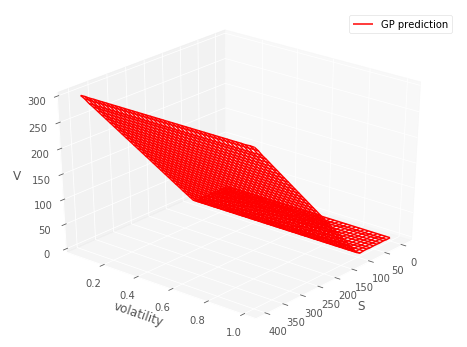

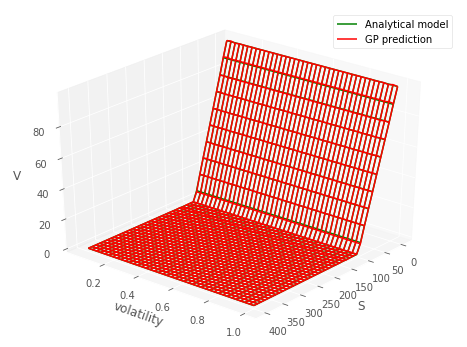

In [21]:
# plot the GP versus the testing data for any point on the timegrid
res = testing_number


x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)



pred_plot  =  portfolio['call']['preds'][0].reshape(res,res) 
test_plot = portfolio['call']['y_tests'][0].reshape(res,res) 

#p
ax.set_xlabel('S')
ax.set_ylabel('volatility')
ax.set_zlabel('V')
ax.legend(loc = 'best', prop={'size':10})


x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)

pred_plot  =  portfolio['put']['preds'][0].reshape(res,res) 
test_plot = portfolio['put']['y_tests'][0].reshape(res,res) 


#pred_plot  =  np.array(preds[0].mean()[:,1].reshape(res,res)) #  portfolio['call']['preds'][0].reshape(res,res) 
#test_plot = portfolio['call']['y_tests'][0].reshape(res,res)
#test_plot = np.array(y_tests[0][:,1].reshape(res,res))
#plt.subplot(1, 2, 2)
plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')

plt.rcParams['axes.facecolor'] = 'white'
ax = plt.axes(projection='3d')

angle = 40
ax.view_init(30, angle)
ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Analytical model')
ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP prediction' )
ax.set_xlabel('S')
ax.set_ylabel('volatility')
ax.set_zlabel('V')
ax.legend(loc = 'best', prop={'size':10})

    #plt.draw()
#plt.pause(.001)

### Derivative approximation convergence properties

## vega

In [145]:
time = 1.0
S0 = 100
price = lambda x: bsformula(1, S0, K, r, time, x, 0)[0]
vega = lambda x: bsformula(1, S0, K, r, time, x, 0)[2]

In [146]:
y_test = []
y_prime_test = []
testing_number = 150
x_test = np.array(np.linspace(0.01,1.0-0.01, testing_number), dtype='float32').reshape(testing_number, 1)

for idx in range(len(x_test)):
        #y_test.append(PyHeston.HestonCall(S0,x_test[idx], K, time, r, lmbda, meanV, sigma, rho, 0.4))
        #y_prime_test.append(HestonVega(S0,K,time,r,lmbda,meanV,sigma, x_test[idx],rho, 'C', N=256))
        y_test.append(price(x_test[idx]))
        y_prime_test.append(vega(x_test[idx]))
        
        
y_test = np.array(y_test)
y_prime_test = np.array(y_prime_test)

In [147]:
f_primes = []
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
time = 1.0
for i in range(10):
    training_number=(i+1)*10
    x_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
   
    y_train = []
    
    for idx in range(len(x_train)):
        #y_train.append(PyHeston.HestonCall(S0, x_train[idx], K, time, r, lmbda, meanV, sigma, rho, 0.4))
        y_train.append(price(x_train[idx]))
    y_train = np.array(y_train)
    gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
    gp.fit(x_train,y_train)
    y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    print(gp.kernel_)
    
    l = gp.kernel_.length_scale
    # Kernel= sklearn.metrics.pairwise.rbf_kernel(x_train, x_train, gamma=0.5/(l*l))
    rbf= gaussian_process.kernels.RBF(length_scale=l)
 
    Kernel= rbf(x_train, x_train)
    K_y = Kernel + np.eye(training_number) * 1e-8
    L = sp.linalg.cho_factor(K_y)
    alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    #alpha = scipy.linalg.cho_solve(L, alpha_p)
    
    k_s = rbf(x_test, x_train)

    k_s_prime = np.zeros([len(x_test), len(x_train)])
    for i in range(len(x_test)):
        for j in range(len(x_train)):
            k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
    f_prime = np.dot(k_s_prime, alpha_p)
    f_primes.append(f_prime)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00251364]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00775483]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00421431]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.19)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.03232473]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.215)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.17452979]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.228)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-64.95125675]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.53504944]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.233)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([11.37462592]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.236)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.65761149]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-129.36236513]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.94828291]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/g

RBF(length_scale=0.237)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-42.80619943]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.236)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.00213575]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.54888245]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.239)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.99893662]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.24)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.03201294]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.24)


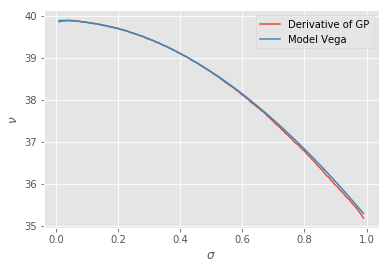

In [148]:
plt.plot(x_test,f_primes[9], label='Derivative of GP')
#plt.plot(x_test, y_pred)
plt.plot(x_test, y_prime_test, label='Model Vega')
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend()

In [149]:
MSEs = []
for i in range(10):
    MSEs.append(np.mean((f_primes[i]-np.array(y_prime_test).flatten())**2))   

In [152]:
rEs = []
for i in range(10):
    rEs.append(np.mean(np.abs(f_primes[i]-np.array(y_prime_test).flatten())/np.array(y_prime_test).flatten()))   

In [153]:
rEs

[0.04224760458119317,
 0.041193945191087,
 0.04141775079893849,
 0.041388596949752075,
 0.04149324353301511,
 0.041392925707853044,
 0.04156041741895365,
 0.04132014141868942,
 0.04147699782703422,
 0.041513325130872206]

Text(0.5,0,'training size')

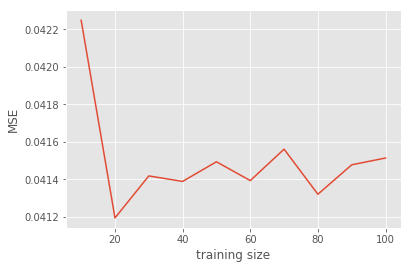

In [154]:
plt.plot((arange(10)+1)*10,rEs)
plt.ylabel('MSE')
#plt.yscale('log')
plt.xlabel('training size')

## delta

In [228]:
time = 1.0
#v0 = 100
sigma = 0.1
price = lambda x: bsformula(1, lb+(ub-lb)*x, K, r, time, sigma, 0)[0]
delta = lambda x: bsformula(1, lb+(ub-lb)*x, K, r, time, sigma, 0)[1]

In [229]:
y_test = []
y_prime_test = []
testing_number = 150
x_test = np.array(np.linspace(0.01,1.0-0.01, testing_number), dtype='float32').reshape(testing_number, 1)

for idx in range(len(x_test)):
        #y_test.append(PyHeston.HestonCall(lb+ (ub-lb)*x_test[idx], v0, K, time, r, lmbda, meanV, sigma, rho, 0.4))
        #y_prime_test.append(HestonDelta(lb+ (ub-lb)*x_test[idx], K, time,r,lmbda,meanV,sigma, v0,rho, 'C', N=256))
        y_test.append(price(x_test[idx]))
        y_prime_test.append(delta(x_test[idx]))
y_test = np.array(y_test)
y_prime_test = np.array(y_prime_test)

In [230]:
f_primes = []
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
time = 1.0
for i in range(10):
    training_number=(i+1)*10
    x_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
   
    y_train = []
    
    for idx in range(len(x_train)):
        y_train.append(price(x_train[idx]))
        #y_train.append(PyHeston.HestonCall(lb+(ub-lb)*x_train[idx], v0, K, time, r, lmbda, meanV, sigma, rho, 0.4))
    y_train = np.array(y_train)
    gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
    gp.fit(x_train,y_train)
    y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    print(gp.kernel_)
    
    l = gp.kernel_.length_scale
    # Kernel= sklearn.metrics.pairwise.rbf_kernel(x_train, x_train, gamma=0.5/(l*l))
    rbf= gaussian_process.kernels.RBF(length_scale=l)
 
    Kernel= rbf(x_train, x_train)
    K_y = Kernel + np.eye(training_number) * 1e-8
    L = sp.linalg.cho_factor(K_y)
    alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    #alpha = scipy.linalg.cho_solve(L, alpha_p)
    
    k_s = rbf(x_test, x_train)

    k_s_prime = np.zeros([len(x_test), len(x_train)])
    for i in range(len(x_test)):
        for j in range(len(x_train)):
            k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
    f_prime = np.dot(k_s_prime, alpha_p)
    f_primes.append(f_prime)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.09683663]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.66604268]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.32738006]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gau

RBF(length_scale=0.144)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.67306967]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.0916)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.05701205]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.94979102]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.0637)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


RBF(length_scale=0.0533)
RBF(length_scale=0.0486)
RBF(length_scale=0.0489)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([157.04252243]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.0488)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6146.52280664]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.0488)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.79727173]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


RBF(length_scale=0.0488)
RBF(length_scale=0.0487)


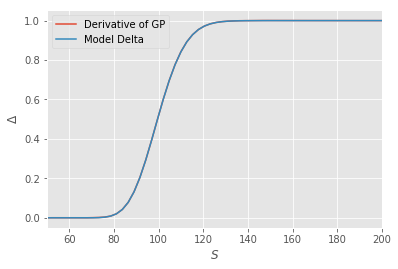

In [232]:
plt.plot(lb+(ub-lb)*x_test,f_primes[9]/(ub-lb), label='Derivative of GP')
#plt.plot(x_test, y_pred)
plt.plot(lb+(ub-lb)*x_test, y_prime_test, label='Model Delta')
plt.xlabel('$S$')
plt.ylabel('$\\Delta$')
plt.xlim([50,200])
plt.legend()

In [138]:
MSEs = []
for i in range(10):
    MSEs.append(np.mean((f_primes[i]/(ub-lb)-np.array(y_prime_test).flatten())**2))   

Text(0.5,0,'training size')

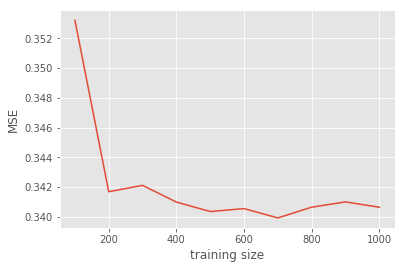

In [142]:
plt.plot((arange(10)+1)*100,MSEs)
plt.ylabel('MSE')
#plt.yscale('log')
plt.xlabel('training size')

In [156]:
""" Simulate dynamics under Heston """ 
import scipy.linalg as spl


def heston(S0, V0, mu, kappa, theta, sigma, rho, T = 1., N = 10): 
    
    dt = T/ float(N) 
    S = [S0]
    V = [V0]
    
    Sigma = np.ones([2,2])*dt
    Sigma[0,1] = rho*dt
    Sigma[1,0] = rho*dt
    L = spl.cholesky(Sigma, lower=True)
    

    for i in range(N): 
        
        y = np.dot(L, np.random.randn(2,1))
        dS = S[-1]*(mu*dt +  np.sqrt(V[-1])*y[0])
        dV = kappa*(theta - V[-1])*dt +  sigma*np.sqrt(V[-1])*y[1]
        S.append(S[-1] + dS) 
        V.append(V[-1] + dV) 
    
    return np.arange(N + 1)*dt, np.array(S), np.array(V)

# CVA

In [226]:
r0 = 0.0002
T= 2.0 # final simulation time
n_sim_dt = 100

#pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
#hzrates = [0.02 for i in range(11)]
#pd_curve = ql.HazardRateCurve(pd_dates,hzrates,ql.Actual365Fixed())
#pd_curve.enableExtrapolation()
#portfolio['put']['EE']= np.array([0.0]*(nt-1))
#portfolio['call']['EE']= np.array([0.0]*(nt-1))
#portfolio['put']['EE_GP']= np.array([0.0]*(nt-1))
#portfolio['call']['EE_GP']= np.array([0.0]*(nt-1))
#portfolio['call']['var']= np.array([0.0]*(nt-1))
#portfolio['put']['var']= np.array([0.0]*(nt-1))

# simulate underlying Heston dynamics
stride = n_sim_dt/(nt-1)
idx = np.arange(0,n_sim_dt+1,stride, dtype=int)

M = 1000 #num_paths
J = 100 # for sampling from prior
seed = 777
np.random.seed(seed) 

mins= 99999
maxs=-99999
min_sigma= 99999
max_sigma=-99999

pi_tilde = np.array([0.0]*(nt-1)*M*J, dtype='float32').reshape((nt-1), M, J)
pi = np.array([0.0]*(nt-1)*M*J, dtype='float32').reshape((nt-1), M, J)
pi_var = np.array([0.0]*(nt-1)*M*J, dtype='float32').reshape((nt-1), M, J)


S0 = 100
v0_mean = 0.1
v0_std = 0.2


v0s = []
cva_vars = []

for j in range(J):
    
 v0=(v0_mean+ v0_std*np.random.randn(1))**2
 v0s.append(v0)
 for m in range(M):
    
  # put prior on v0
  
  #v0= np.random.randn(v0_mean, v0_std)**2 # chi-sq distribution
  if (v0<0.05):
    v0=0.05
  elif (v0>1.0):
    v0=1.0
    
  #v0 = np.random.noncentral_chisquare(1, v0_mean, 1)
  t, S, V =heston(S0, v0, r0, lmbda, meanV, sigma, rho, T, n_sim_dt)
  i = 1 
  if (m%100==0):  
    print(mins, maxs, min_sigma, max_sigma, m, j)
  for time in timegrid[1:]:
    S_= S[idx[i]] # simulated S
    if (S_<mins):
        mins=S_
    if (S_>maxs):
        maxs=S_
    #print min(S), max(S)
    sigma_ = np.sqrt(V[idx[i]]) # simulated sigma
    if (sigma_<min_sigma):
        min_sigma=sigma_
    if (sigma_>max_sigma):
        max_sigma=sigma_
   
    # assume unit portfolio weights
    pred_= 0
    v_ = 0
    var_ =0 
    for key in portfolio.keys():
       pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb),sigma_]).reshape(1,-1),return_std=True) 
       pred_ += np.max(pred,0)
       var_ += std*std 
       #portfolio[key]['EE_GP'][i-1]
       
       if key=='call':
          v_ += np.max(PyHeston.HestonCall(S_, sigma_, K, time, r, lmbda, meanV, sigma, rho, 0.4),0)
       else:
          v_ += np.max(PyHeston.HestonPut(S_, sigma_, K, time, r, lmbda, meanV, sigma, rho, 0.4),0)
       #portfolio[key]['EE'][i-1] += v
    pi_tilde[i-1,m,j] = pred_
    pi[i-1,m,j] = v_
    pi_var[i-1,m,j] = var_
    
        
    
    i += 1

99999 -99999 99999 -99999 0 0


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


40.103844854877245 182.09989629299517 0.10350914446103042 0.3691671321460087 100 0
22.39082734355585 182.09989629299517 0.10350914446103042 0.40892647327458237 200 0
22.39082734355585 195.91537554922388 0.07409590113579809 0.40892647327458237 300 0
18.219791097308203 195.91537554922388 0.07409590113579809 0.4314877243013071 400 0
18.219791097308203 195.91537554922388 0.05432607542490554 0.4314877243013071 500 0
18.219791097308203 195.91537554922388 0.05432607542490554 0.4314877243013071 600 0
18.219791097308203 195.91537554922388 0.05432607542490554 0.4314877243013071 700 0
18.219791097308203 195.91537554922388 0.04728368381021087 0.4314877243013071 800 0
18.219791097308203 195.91537554922388 0.04728368381021087 0.4314877243013071 900 0
18.219791097308203 195.91537554922388 0.04728368381021087 0.4354982407272831 0 1
18.219791097308203 195.91537554922388 0.04728368381021087 0.4354982407272831 100 1
15.853629108176223 195.91537554922388 0.04728368381021087 0.486194583872994 200 1
15.8536

KeyboardInterrupt: 

In [221]:
np.max((v0_mean+ v0_std*np.random.randn(100))**2)

0.3171130293968338

In [158]:
hazard_rate = 0.01
dPD = np.exp(-hazard_rate*(timegrid[:-1])) - np.exp(-hazard_rate*(timegrid[1:]))
recovery = 0.4

In [194]:
# one year CVA distribution
i = 5
EPE_tilde = 0
EPE = 0
t = 1.0
for time in timegrid[6:]:
    EPE_tilde += dPD[i]*pi_tilde[i,:]*np.exp(r*(time-t))
    EPE += dPD[i]*pi_tilde[i,:]*np.exp(r*(time-t))
    
CVA_1_yr_tilde = (1-recovery) * EPE_tilde * np.exp(-r*t)   
CVA_1_yr = (1-recovery) * EPE * np.exp(-r*t)   

In [193]:
# CVA_0
i = 0
EPE_tilde = 0
EPE = 0
t = 0.0
for time in timegrid[1:]:
    EPE_tilde += dPD[i]*np.mean(pi_tilde,axis=1)[i]*np.exp(r*(time-t))
    EPE += dPD[i]*np.mean(pi_tilde, axis=1)[i]*np.exp(r*(time-t))
    
CVA_tilde = (1-recovery) * EPE_tilde
CVA = (1-recovery) * EPE

In [333]:
CVA

array([0.27497998], dtype=float32)

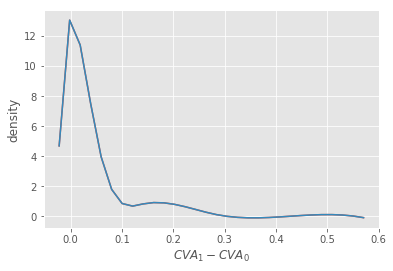

In [197]:
#import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

#N = 1000
#n = N//10
s_tilde = CVA_1_yr_tilde-CVA_tilde   # generate your data sample with N elements
p, x = np.histogram(s_tilde, bins=30, density=T) # bin it into n = N//10 bins
x_tilde = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f_tilde = UnivariateSpline(x_tilde, p, s=30)

s = CVA_1_yr-CVA   # generate your data sample with N elements
p, x = np.histogram(s, bins=30, density=T) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=30)

plt.plot(x_tilde, f_tilde(x))
plt.plot(x, f(x))

plt.xlabel('$CVA_1 - CVA_0$')
plt.ylabel('density')
plt.show()

In [198]:
s_sorted=np.sort(s)
s_tilde_sorted=np.sort(s_tilde)
quantiles = np.array([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999])

In [183]:
idx = np.array(len(s_sorted)*quantiles, dtype=int)

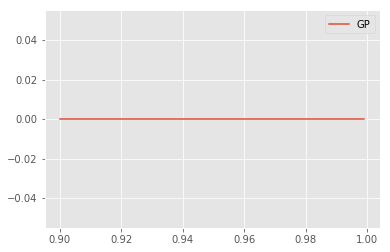

In [199]:

plt.plot(quantiles, s_tilde_sorted[idx]-s_sorted[idx], label='GP')
#plt.plot(quantiles, s_sorted[idx], label='Option Model')
plt.legend()

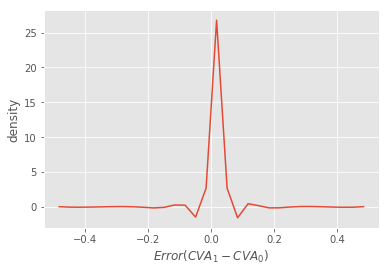

In [196]:
s = (CVA_1_yr_tilde-CVA_tilde) - (CVA_1_yr - CVA)   # generate your data sample with N elements
p, x = np.histogram(s, bins=30, density=T) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=30)
plt.plot(x, f(x))
plt.xlabel('$Error(CVA_1 - CVA_0)$')
plt.ylabel('density')
plt.show()

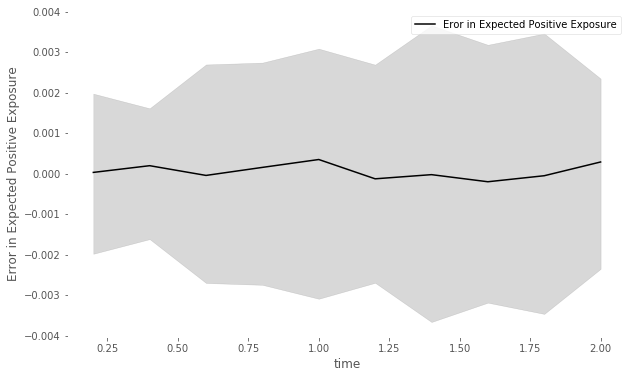

In [295]:
# Error plot
up = np.mean(pi_tilde, axis=1) -np.mean(pi_tilde, axis=1)+2.0*np.sqrt(np.mean(pi_var, axis=1))   # 95% confident interval 
down = np.mean(pi_tilde, axis=1) -np.mean(pi_tilde, axis=1)- 2.0*np.sqrt(np.mean(pi_var, axis=1))   # 95% confident interval 

#down = - 2.0*np.sqrt(var_2/M)

plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(timegrid[1:], np.mean(pi, axis=1)-np.mean(pi_tilde, axis=1), color = 'black', label = 'Eror in Expected Positive Exposure')
#plt.plot(timegrid[1:], np.mean(pi_tilde, axis=1), color = 'red', label = 'Expected Positive Exposure (GP)')

#plt.plot(timegrid[1:], EE_2/M, color = 'black', label = 'GP Exposure')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(timegrid[1:].flatten(), np.array(down), np.array(up), color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in Expected Positive Exposure')
plt.legend(loc = 'best', prop={'size':10})

In [302]:
x = np.array([100, 20*20, 30*30, 40*40, 50*50])
CVA_GPs_err=np.array([3.70e-3, 5.51e-5, 3.072e-6, 1.4e-6, 8.2e-7])
ups = np.array([3.74e-3, 1.42e-3, 0.0008382935917179424, 4e-4, 2.3e-4])
downs =np.array([-3.74e-3, -1.42e-3 , -0.0008382935917181644, -4e-4, -2.3e-4 ])

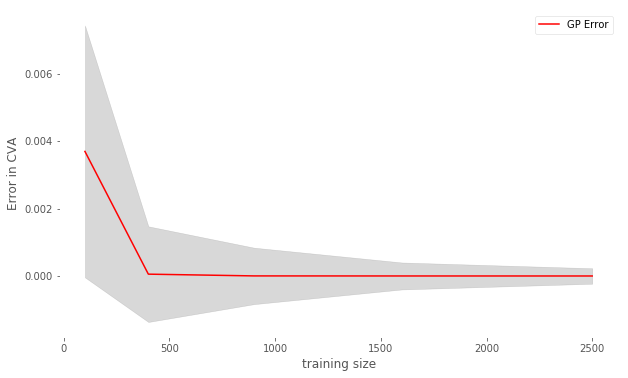

In [303]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x, CVA_GPs_err, color = 'red', label = 'GP Error')
#plt.plot(train_x, train_y, color = 'black', label = 'Analytical Model')
#plt.scatter(test_x, test_y, s = 150, color = 'black', marker = "+")
plt.fill_between(x, CVA_GPs_err+ups, CVA_GPs_err+downs, color = 'grey', alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('training size')
plt.ylabel('Error in CVA')
plt.legend(loc = 'best', prop={'size':10})